# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    hv = HashingVectorizer(n_features=2 ** 20, alternate_sign=False)
    X_hv = hv.fit_transform(toxic_data.comment_text)
    print("Shape of HashingVectorizer X:")
    print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_hv)
    
    
    # importing bad words 
    badwords = set(line.strip() for line in open('badwords.txt'))
    import nltk
    tokenized_sents = pd.Series([]) 
    toxic_data['tokenized_sents'] = toxic_data.apply(lambda row: nltk.word_tokenize(row['comment_text']), axis=1)

    toxicValues = []
    sentencePosition = []
    arraylength = len (toxic_data['tokenized_sents'])
    for index in range(0,arraylength):
        sentencePosition.append(index)
        badDetected = 0
        for word in toxic_data['tokenized_sents'][index]:
            word = word.lower()
            if word in badwords:
                badDetected =1
        if badDetected:
            toxicValues.append(1)
        else:
            toxicValues.append(0)

    toxicValues = np.array(toxicValues)
    sentencePosition = np.array(sentencePosition)
    temp = pd.Series(data=toxicValues, index=sentencePosition)
    print(toxicValues)
    print(sentencePosition)
    print(temp)
    
    
    toxic_data.insert(2, "temp", temp) 

    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    toxic_data['punc_count1'] = toxic_data['comment_text'].str.count("\!")
    toxic_data['punc_count2'] = toxic_data['comment_text'].str.count("\?")
    toxic_data['punc_count3'] = toxic_data['comment_text'].str.count("\*")
    toxic_data['punc_count4'] = toxic_data['comment_text'].str.count("\$")
    toxic_data['punc_count6'] = toxic_data['comment_text'].str.count("\_")
    toxic_data['punc_count7'] = toxic_data['comment_text'].str.count("\00")
    toxic_data['punc_count5'] = toxic_data['comment_text'].str.len()


    X_quant_features = toxic_data[["temp","word_count",'punc_count','punc_count1','punc_count2','punc_count3','punc_count4','punc_count5', 'punc_count6', 'punc_count7']]

    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = toxic_data['any_toxic']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../final_data/toxiccomments_train.csv', my_random_seed=11)

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
# from sklearn import linear_model
# ols = linear_model.SGDClassifier(loss="squared_loss")
# ols.fit(X_train, y_train)

# ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
# ols_performance_train.compute_measures()
# print(ols_performance_train.performance_measures)

### MODEL: SVM, linear

In [6]:
# from sklearn import linear_model
# svm = linear_model.SGDClassifier()
# svm.fit(X_train, y_train)

# svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
# svm_performance_train.compute_measures()
# print(svm_performance_train.performance_measures)

### MODEL: logistic regression

In [7]:
# from sklearn import linear_model
# lgs = linear_model.SGDClassifier(loss='log')
# lgs.fit(X_train, y_train)

# lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
# lgs_performance_train.compute_measures()
# print(lgs_performance_train.performance_measures)

### MODEL: Naive Bayes

In [8]:
# from sklearn.naive_bayes import MultinomialNB
# nbs = MultinomialNB()
# nbs.fit(X_train, y_train)

# nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
# nbs_performance_train.compute_measures()
# print(nbs_performance_train.performance_measures)

### MODEL: Perceptron

In [9]:
# from sklearn import linear_model
# prc = linear_model.SGDClassifier(loss='perceptron')
# prc.fit(X_train, y_train)

# prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
# prc_performance_train.compute_measures()
# print(prc_performance_train.performance_measures)

### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha= 100.0,
 class_weight= None,
 copy_X= True,
 fit_intercept= True,
 max_iter= None,
 normalize= True,
 random_state=11,
 solver= 'auto',
 tol= 0.001)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12950, 'Neg': 114706, 'TP': 12462, 'TN': 108490, 'FP': 6216, 'FN': 488, 'Accuracy': 0.947483862881494, 'Precision': 0.6672020558946354, 'Recall': 0.9623166023166023, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
# from sklearn.ensemble import RandomForestClassifier
# rdf = RandomForestClassifier(max_depth=2, random_state=0)
# rdf.fit(X_train, y_train)

# rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
# rdf_performance_train.compute_measures()
# print(rdf_performance_train.performance_measures)

### ROC plot to compare performance of various models and fits

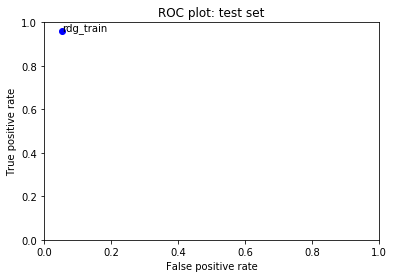

In [12]:
fits = [rdg_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [13]:
rdg_predictions = rdg.predict(X_train)

### let's look at some false positives:

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(rdg_predictions)):
    if (rdg_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
1034
Awww, man... 

...this ruins everything!
* * * * * * * * * 
1141
okay you guys i'm really depressed so please stop messing with me, please
* * * * * * * * * 
1152
"
 Oh whatever, you and your pal Melbourne have been up each other's bums for days on this. Neither of you wants to admit that an episode's credits work as a source for the episode so you dogpile on the person who calls you out on your nonsense. Did Melbourne come crying on your talk page about the big bad editor who hurt his feewings? Asking an editor who's been complaining for weeks about sourcing something that's ALREADY SOURCED to the episode for a source that satisfies his meaningless complaint isn't a ""personal attack"" anywhere outside the mind of an editor who's desperate to push his agenda. 76.204.89.112  "
* * * * * * * * * 
1307
hey smoking hottie it's
lol just my chelz hehe
see ya
* * * * * * * * * 
1425
thumbs up* Truce! *hugs*
* * * * * * * * * 
1626
You are full of it, since I

23026
the Pigs in Animal Farm).
* * * * * * * * * 
23900
One other question.  Is NAMBLA also argueing for the age of consent being changed for boys that want to have sex with older females?
* * * * * * * * * 
24833
"
Excuse me ""incivil nonsense""? Read what I've written and please for the sake of the world don't push your pro-Nazi beliefs on me.  Talk Contribs "
* * * * * * * * * 
25311
ps i can change my ip address, create a new account anyday and get my revenge anyday.
* * * * * * * * * 
25457
Hey child! 

Hello child of the dogs..2.48.32.90
* * * * * * * * * 
25517
Yeah, Zenwhat, stop trolling, ok?
* * * * * * * * * 
25853
"

 Bulgars 

omg!! you are an admin and you protect the people who vandalise the ""Bulgars"" article. these attackers are pan-slavic ultra-nationalists and they dont want to see the word beginning with ""Turk"". you help them remove reliable sources. Old Bulgars are changing into slavs by your hand... great!  "
* * * * * * * * * 
25951
RE: thegodstemplate 

No, 

44134
"
Yes yes and yes! I don't know the songs directly by name, but if it were to play, I know I'd dance my ass off cause songs like those are classics!!! D I was at a dragqueen bar this weekend, and ""Countdown"" came on, and me and my friend got up and danced all over the place! Hahahahahahaaa!!! I might be a white-boy, but i sure as hell don't dance like one! ;D  STACK STACK STACK "
* * * * * * * * * 
44231
You callin' me a liar?!
* * * * * * * * * 
44483
hmm man i swear like i understand that and its totally right.. but like cant u just do it for like 1 minute.. like millions of ppl will hardly see it.. and they will just assume u havnt deleted sum1's edit yet.. u get wat i mean
* * * * * * * * * 
44844
Oh boy I can still edit this page!
* * * * * * * * * 
45813
Nor, oddly a dictatorship where lonesome boys get off on meaningless power trips.  ColScott
* * * * * * * * * 
46208
"

""Please refrain from trolling and vandalising Wikipedia on a personal basis or you will be blocked. 

56203
A heads up
I just wanted to let you know that I have reverted your last edit to Talk:Blood of the Fold per my interpretation of wikipedia policy. I know this is rapidly becoming a pain in the ass but it is my conviction that this is the correct course of action and I apologise for any grief.
* * * * * * * * * 
56259
":you can take it up in the talk and set t up for peer review or debate settlement if you think there is something wrong with what I have posted

try and NOT coplying and pasting crap from your endless line-up of ""disruptive"" editors

and try and keep uas all out of that black hole over there.

"
* * * * * * * * * 
56614
I know what you mean. You definitely wrong and certainly retarded, but I know what you're trying to say.
* * * * * * * * * 
57955
"
Yep, you're right - it was just me! ) Thanks a bunch. –  ⁂ "
* * * * * * * * * 
58420
I would seem Gamaliel has a Joehazelton fixation. Wake up, I'm not Joehazelton.  Yet Gamaliel and Goethean forget there is about one 

78753
Is this all you people do?  Get a life, girlfriend, job, anything.
* * * * * * * * * 
79650
"*LoL @ ""connection to Obama"". Here' what Obama Really thinks of Cuba:

""Throughout my entire life, there has been injustice and repression in Cuba. Never, in my lifetime, have the people of Cuba known freedom. Never, in the lives of two generations of Cubans, have the people of Cuba known democracy. (...) This is the terrible and tragic status quo that we have known for half a century - of elections that are anything but free or fair (...) I won't stand for this injustice, you won't stand for this injustice, and together we will stand up for freedom in Cuba,""

Any so-called leftist-revolutionary who thinks Obama will be any different from whitey is simply deluding themselves. He's in fact, a great tool for the bourgeoisie to fool revolutionaries from all communities. Isabel is just some dumb wannabe commie who jumped on the Obama bandwagon. They are really just silly social democrats 

100402
'I am nobodies sock-puppet. this is tripe.
* * * * * * * * * 
101212
Its been a while 

Ok. I just had my fun. So now Im serious. I know your a strong headed, stuborn woman so I'll just say this. When I was blocked, it gave me time to think about how hard I've made your life. And I know this apology could never make up for the damage your page has faced, so I just want you to know that I am sorry. No, I wont do anything, and I dont expect you to believe me. I have just come back to apalogise and I wont be editing again. I am not sucking up to you. Infact, I think you are a terrible example for a lady and disgracefull to all women. But it is probable because I made your life harder then it is. I realised this when I also realised that you are taking time out of your day to make the site better. And I aplaud you for that. I have finally found a religion and have deeply regreted my actions. Also, since I will probably be blocked after this,(and since my fingers hurt by now) tell El

124259
Note to Bertil Videt=
Bertil
I started to think that there is something seriosly wrong with your ability to interpret the factual information. With this going in your virtual world, your master's degree will be a fake one.
* * * * * * * * * 
125104
"

 This Isn't War 

what about his comment about ""medication"" ... back off."
* * * * * * * * * 


---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
# ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
# ols_performance_test.compute_measures()
# print(ols_performance_test.performance_measures)

### MODEL: SVM, linear

In [16]:
# svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
# svm_performance_test.compute_measures()
# print(svm_performance_test.performance_measures)

### MODEL: logistic regression

In [17]:
# lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
# lgs_performance_test.compute_measures()
# print(lgs_performance_test.performance_measures)

### MODEL: Naive Bayes

In [18]:
# nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
# nbs_performance_test.compute_measures()
# print(nbs_performance_test.performance_measures)

### MODEL: Perceptron

In [19]:
# prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
# prc_performance_test.compute_measures()
# print(prc_performance_test.performance_measures)

### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3275, 'Neg': 28640, 'TP': 2852, 'TN': 26672, 'FP': 1968, 'FN': 423, 'Accuracy': 0.9250822497258342, 'Precision': 0.591701244813278, 'Recall': 0.8708396946564886, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
# rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
# rdf_performance_test.compute_measures()
# print(rdf_performance_test.performance_measures)

### ROC plot to compare performance of various models and fits

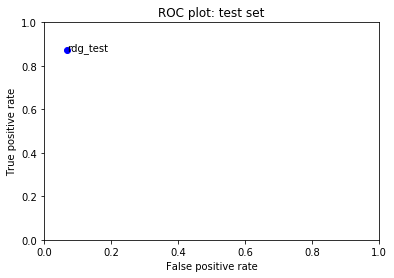

In [22]:
fits = [rdg_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [25]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='../final_data/toxiccomments_test.csv', my_random_seed=11, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 1048576)
[1 0 0 ... 0 0 0]
[     0      1      2 ... 153161 153162 153163]
0         1
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        1
11        1
12        0
13        0
14        0
15        0
16        0
17        0

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [26]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.24860933378600716


In [27]:
raw_data.head()

,id,comment_text,temp,tokenized_sents,word_count,punc_count,punc_count1,punc_count2,punc_count3,punc_count4,punc_count6,punc_count7,punc_count5
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,1,"[Yo, bitch, Ja, Rule, is, more, succesful, the...",72,10,0,0,0,0,0,0,367
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0,"[==, From, RfC, ==, The, title, is, fine, as, ...",13,1,0,0,0,0,0,0,50
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0,"[``, ==, Sources, ==, *, Zawe, Ashton, on, Lap...",16,0,0,0,1,0,0,0,54
3,00017563c3f7919a,":If you have a look back at the source, the in...",0,"[:, If, you, have, a, look, back, at, the, sou...",38,3,0,0,0,0,0,0,205
4,00017695ad8997eb,I don't anonymously edit articles at all.,0,"[I, do, n't, anonymously, edit, articles, at, ...",7,1,0,0,0,0,0,0,41


In [28]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [29]:
my_submission.shape

(153164, 2)

In [30]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('../final_data//toxiccomments_submission_shirley.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation